In [3]:
#Notebook Header (meta)

In [6]:
# House Price Prediction 🏡
#**Author:** Sunil Kumar  
#**Date:** 2025-08-31  
#**Description:** Predict median house value using the California Housing dataset.  
#**Thanks:** Thank you for this opportunity — I learned a lot! 🙏


In [7]:
# If packages missing, uncomment and run the pip lines once:
# %pip install pandas numpy matplotlib seaborn scikit-learn joblib

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set_style("whitegrid")
RSEED = 42


In [8]:
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
housing = pd.read_csv(url)
print("Shape:", housing.shape)
housing.head()


Shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()
print("\nMissing values per column:\n", housing.isnull().sum())
housing.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Missing values per column:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_v

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


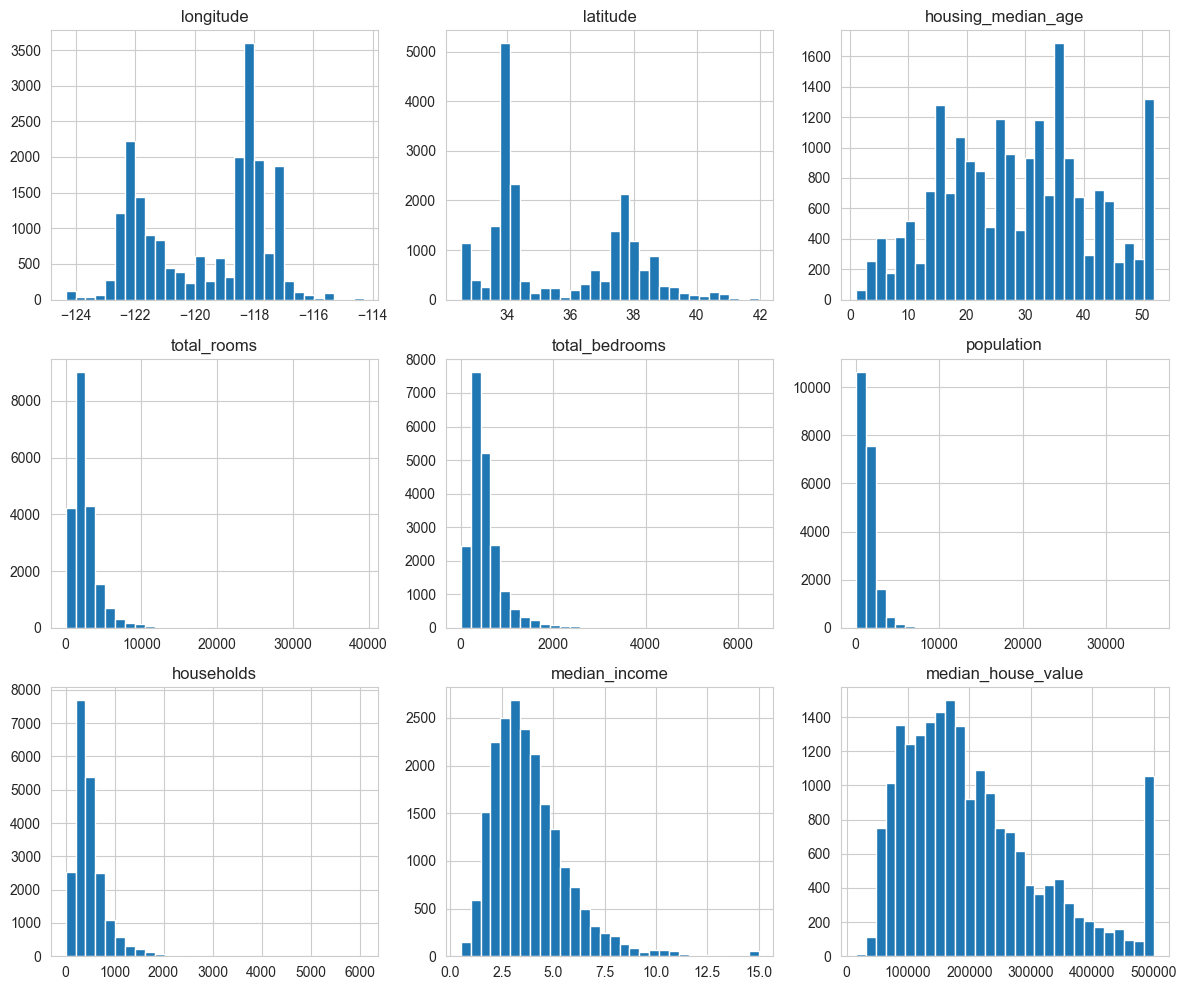

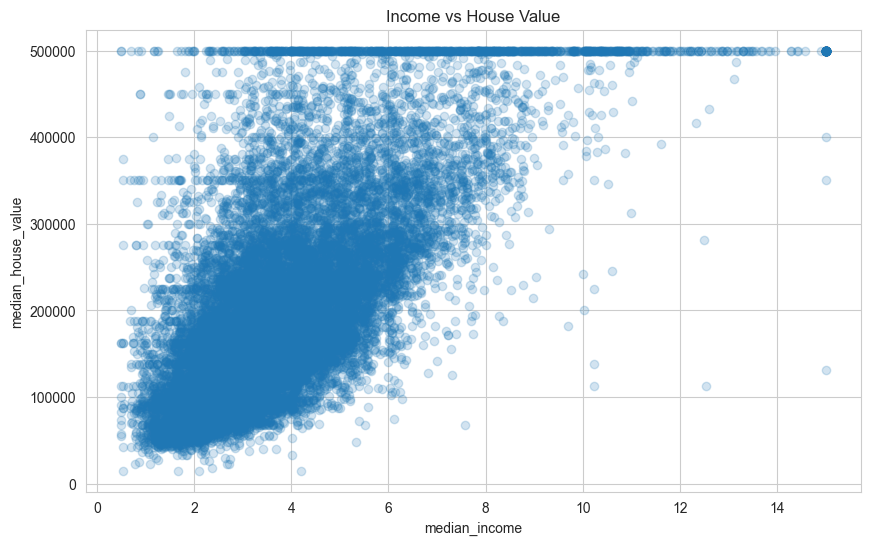

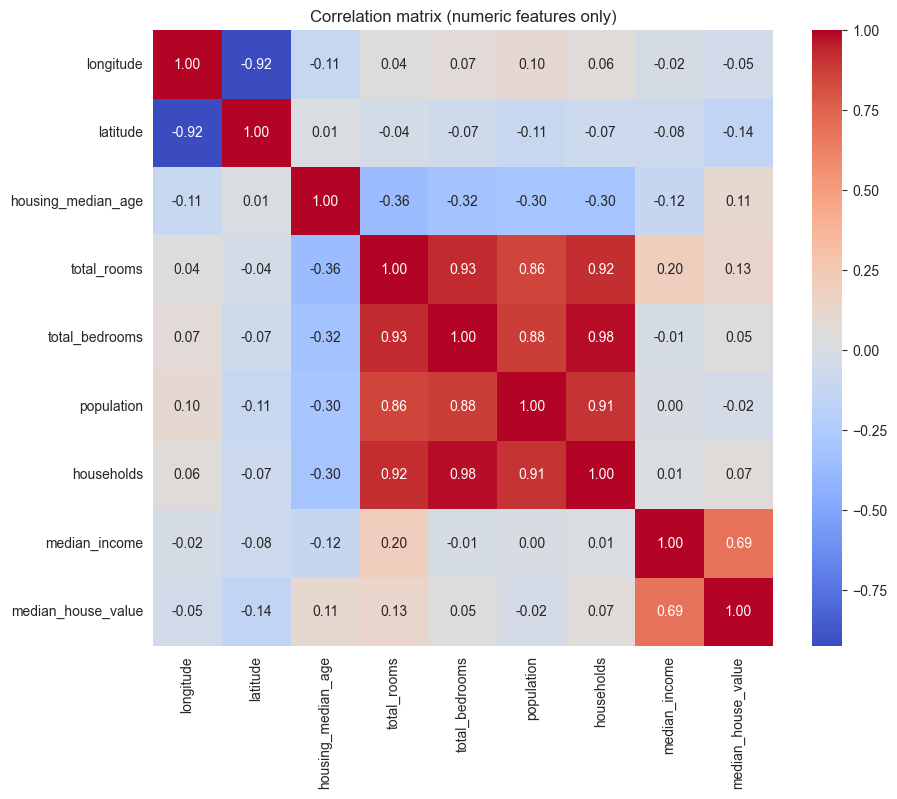

In [11]:
# Cell 4 — EDA (fixed: numeric-only correlation)
housing.hist(bins=30, figsize=(12,10))
plt.tight_layout()
plt.show()

plt.scatter(housing['median_income'], housing['median_house_value'], alpha=0.2)
plt.xlabel('median_income')
plt.ylabel('median_house_value')
plt.title('Income vs House Value')
plt.show()

# CORRELATION: numeric columns only
num_cols = housing.select_dtypes(include=[np.number]).columns
corr = housing[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix (numeric features only)')
plt.show()


In [12]:
# Add engineered features (safe to add before split — based on existing cols)
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467


In [13]:
# Create income category for stratified sampling
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0.,1.5,3.0,4.5,6.0, np.inf],
                               labels=[1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RSEED)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Drop income_cat from datasets (we used it only for stratification)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print("Train shape:", strat_train_set.shape, "Test shape:", strat_test_set.shape)


Train shape: (16512, 13) Test shape: (4128, 13)


In [15]:
housing_train = strat_train_set.copy()
housing_test = strat_test_set.copy()

X_train = housing_train.drop("median_house_value", axis=1)
y_train = housing_train["median_house_value"].copy()

X_test = housing_test.drop("median_house_value", axis=1)
y_test = housing_test["median_house_value"].copy()


In [16]:
# Identify columns
num_attribs = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Keep only the categorical column(s)
cat_attribs = ['ocean_proximity']

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numeric pipeline: median imputer + scaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

full_preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])


In [17]:
# Define pipelines with model as last step
pipelines = {
    "LinearRegression": Pipeline([('preproc', full_preprocessing),
                                  ('model', LinearRegression())]),
    "DecisionTree": Pipeline([('preproc', full_preprocessing),
                              ('model', DecisionTreeRegressor(random_state=RSEED))]),
    "RandomForest": Pipeline([('preproc', full_preprocessing),
                              ('model', RandomForestRegressor(random_state=RSEED))])
}

def evaluate_model(pipe, X_test, y_test):
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    results[name] = evaluate_model(pipe, X_test, y_test)

pd.DataFrame(results).T


,MAE,RMSE,R2
LinearRegression,48966.308506,66803.138908,0.657592
DecisionTree,45570.805717,70660.850106,0.616903
RandomForest,31785.840693,48359.282554,0.820564


In [18]:
from sklearn.model_selection import cross_val_score

def display_cv_scores(pipe, X, y, scoring='neg_mean_squared_error', cv=5):
    scores = cross_val_score(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print("RMSE mean:", rmse_scores.mean(), "std:", rmse_scores.std())

for name, pipe in pipelines.items():
    print("----", name)
    display_cv_scores(pipe, X_train, y_train, cv=5)


---- LinearRegression
RMSE mean: 68433.85637884261 std: 807.4723723859449
---- DecisionTree
RMSE mean: 70380.38182225508 std: 1774.6864414600607
---- RandomForest
RMSE mean: 50575.4837938497 std: 890.0959743603937


In [ ]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

rf_pipe = pipelines['RandomForest']
grid_search = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate on test set
evaluate_model(best_model, X_test, y_test)


In [ ]:
joblib.dump(best_model, "house_price_pipeline.pkl")
print("Saved: house_price_pipeline.pkl")


In [ ]:
# Load model
model = joblib.load("house_price_pipeline.pkl")

# Example: create a dictionary with same feature names as original X
sample = {
    "longitude": -122.23,
    "latitude": 37.88,
    "housing_median_age": 41,
    "total_rooms": 880.0,
    "total_bedrooms": 129.0,
    "population": 322.0,
    "households": 126.0,
    "median_income": 8.3252,
    # engineered features (if you added them before split)
    "rooms_per_household": 880.0 / 126.0,
    "bedrooms_per_room": 129.0 / 880.0,
    "population_per_household": 322.0 / 126.0,
    "ocean_proximity": "INLAND"
}

sample_df = pd.DataFrame([sample])
predicted = model.predict(sample_df)[0]
print(f"Predicted median house value: ${predicted:,.2f}")


In [ ]:
# Optional: transform target with log1p to reduce skew
y_train_log = np.log1p(y_train)

pipe_for_log = Pipeline([('preproc', full_preprocessing),
                         ('model', RandomForestRegressor(random_state=RSEED))])
pipe_for_log.fit(X_train, y_train_log)

# Predict and invert transform
pred_log = pipe_for_log.predict(X_test)
pred = np.expm1(pred_log)
evaluate_model(lambda X: pred, X_test, y_test)  # simple demonstration; prefer proper pipeline flow


In [ ]:
# streamlit run app.py
import streamlit as st
import joblib
import pandas as pd

model = joblib.load("house_price_pipeline.pkl")

st.title("House Price Predictor 🏡")
# create inputs
median_income = st.number_input("Median income", value=3.0)
# ... add more inputs for all required features
if st.button("Predict"):
    input_dict = {
        "longitude": -122.23,
        "latitude": 37.88,
        "housing_median_age": 41,
        "total_rooms": 880,
        "total_bedrooms": 129,
        "population": 322,
        "households": 126,
        "median_income": median_income,
        "rooms_per_household": 880/126,
        "bedrooms_per_room": 129/880,
        "population_per_household": 322/126,
        "ocean_proximity": "INLAND"
    }
    df = pd.DataFrame([input_dict])
    pred = model.predict(df)[0]
    st.write(f"Predicted median house value: ${pred:,.2f}")
